# Convergence to gaussian projections

In [1]:
import numpy as np
import proplot as pplt
from ipywidgets import interact
from ipywidgets import widgets

import mentflow as mf

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

max(x) = 1.585837
std(x) = 1.0014046


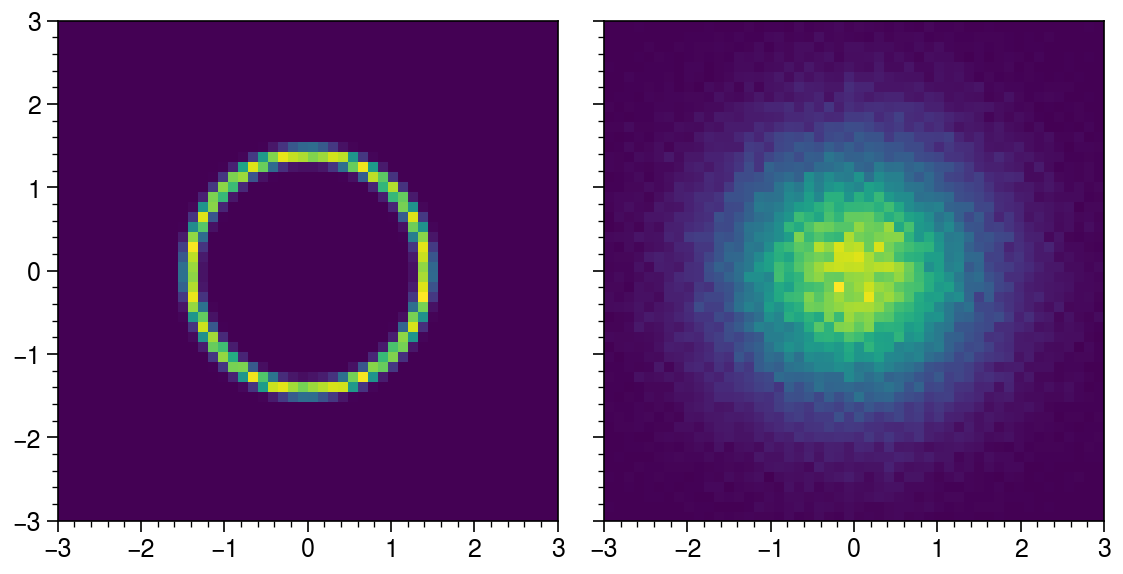

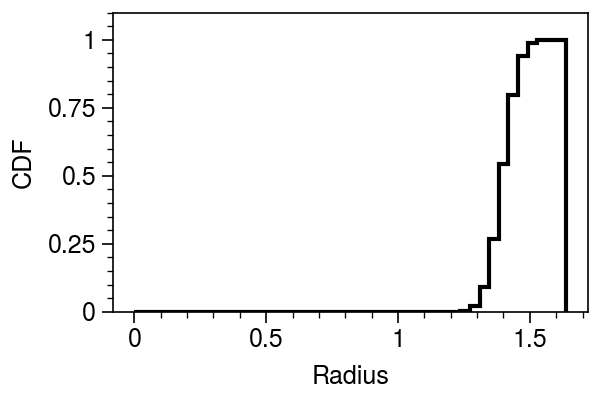

interactive(children=(Dropdown(description='dist_name', index=2, options=('gaussian', 'hollow', 'kv', 'rings',…

In [5]:
@interact(
    dist_name=widgets.Dropdown(
        options=[
            "gaussian",
            "hollow",
            "kv",
            "rings",
            "waterbag",
        ],
        value="kv",
    ), 
    ndim=widgets.IntSlider(min=2, max=10, value=2),
    bins=widgets.IntSlider(min=50, max=125, value=50),
    xmax=widgets.FloatSlider(min=1.0, max=8.0, value=3.0),
    size=widgets.FloatLogSlider(min=4.0, max=6.0, value=(1.00e+05)),
    rhist_bins=widgets.IntSlider(min=25, max=75, value=45),
)
def update(dist_name, ndim, bins, xmax, size, rhist_bins, log_cdf=False):
    dist = mf.dist.get_dist(name=dist_name, ndim=ndim, normalize=True, noise=None)
    
    x = dist.sample(int(size))
    x = x.detach().cpu().numpy()

    print("max(x) =", np.max(x))
    print("std(x) =", np.std(x))

    y = np.random.normal(size=x.shape)
    
    fig, axs = pplt.subplots(ncols=2)
    axs[0].hist2d(x[:, 0], x[:, 1], bins=bins, range=(2 * [(-xmax, xmax)]), density=True)
    axs[1].hist2d(y[:, 0], y[:, 1], bins=bins, range=(2 * [(-xmax, xmax)]), density=True)
    
    r = np.linalg.norm(x, axis=1)
    hist, edges = np.histogram(r, bins=rhist_bins, range=(0.0, np.max(r)))
    for i in range(len(hist)):
        hist[i] = hist[i] / mf.utils.sphere_shell_volume(edges[i], edges[i + 1], d=ndim)
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    fig, ax = pplt.subplots(figsize=(3, 2))
    ax.stairs(cdf, edges, color="black", lw=1.5)
    ax.format(ylabel="CDF", xlabel="Radius", ymax=1.1)
    if log_cdf:
        ax.format(yscale="log", ymin=0.0001, ymax=2.0)
    pplt.show()

Check log-concavity of distribution functions.

In [ ]:
for dist_name in mf.dist.dist_nd.DISTRIBUTIONS:
    radial_dist_func = None
    if dist_name == "hollow":
        radial_dist_func = lambda r: r ** 2.0
    if dist_name == "gaussian":
        radial_dist_func = lambda r: np.exp(-r**2)
    if dist_name == "waterbag":
        radial_dist_func = lambda r: 1.0

    if radial_dist_func is not None:
        print(dist_name)
        
        r = np.linspace(0.0, 4.0, 100)
        fr = [radial_dist_func(r[i]) for i in range(len(r))]
        fr = np.array(fr)
        fr = fr / np.max(fr)
    
        fig, ax = pplt.subplots(figsize=(3, 2))
        ax.plot(r, fr)
        ax.format(yscale="log", ymin=0.001)
        pplt.show()

Show hollow distribution.

In [ ]:
r = np.linspace(0.0, 4.0, 100)
frs = []
for a in np.linspace(0.0, 4.0, 10):
    radial_dist_func = lambda r: r ** a
        
    r = np.linspace(0.0, 4.0, 100)
    fr = [radial_dist_func(r[i]) for i in range(len(r))]
    fr = np.array(fr)
    fr = fr / np.max(fr)
    
    frs.append(fr)

fig, axs = pplt.subplots(figwidth=2.5, figheight=4.0, nrows=2, spany=False)
for fr in frs:
    axs[0].plot(r, fr, color="black")
    axs[1].plot(r, np.ma.log10(fr), color="black")
axs.format(xlabel="r")
axs[0].format(ylabel="f(r)")
axs[1].format(ylabel="log f(r)")
pplt.show()